By: Jack Swisher, Dennis Lin, and Sam Benkelman

In [59]:
import os
import sys
import glob
import time
import datetime
import math
import requests
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import scipy as sp

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style="ticks")

np.random.seed(109)

In [19]:
import tensorflow as tf

print(tf.__version__)  # You should see a 2.0.0 here!

2.0.0


In [2]:
srs_50k = pd.read_csv("50k_srs_songs.csv")
pop_70k = pd.read_csv("top70ksongs.csv")

In [3]:
col_of_interest = ["danceability","energy","key","loudness","mode","speechiness",
                   "acousticness","instrumentalness","liveness", "valence", "tempo", "duration_ms"]

## Description of our EDA ##

For our EDA, we first got data for the songs within each playlist using the Spotify API. The information that we derived from this is described below. We anticipate using the Spotify API further later in our project to get the top playlists to further evaluate the performance of our model.

We do three types of EDA below:
* EDA of information about the playlists (duration of playlist, number of songs from a single artist, number of songs in a playlist)

* EDA of audio features for songs, clustered by playlist

* EDA of audio features for general songs

## Description of Data for Songs

From the spotify API, we were able to get the following audio features for each track. Below, we have listed them with a description of what they represent:

* **DANCEABILITY:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 
* **ENERGY:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.
* **KEY:** The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
* **LOUDNESS:** The overall loudness of a track in decibels (dB) ranging from -60 to 0. Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. 
* **MODE:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* **SPEECHINESS:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
* **ACOUSTICNESS:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. 
* **INSTRUMENTALNESS:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 
* **LIVENESS:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. Values range from 0 to 1 with a value above 0.8 providing strong likelihood that the track is live. 
* **VALENCE:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* **TEMPO:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

## EDA Thought Process and Results for data in Playlists


In [4]:
playlist_df = pd.read_csv("playlist_data.csv")

In [5]:
songs_in_playlist = playlist_df.groupby(["fid", "pid"]).pos.max()

In [6]:
songs_in_playlist.describe()

count    1000000.000000
mean          65.346428
std           53.669358
min            4.000000
25%           25.000000
50%           48.000000
75%           91.000000
max          375.000000
Name: pos, dtype: float64

This tells us the distribution of the number of songs in a playlist. The mean is about 65 with a standard deviation of about 54. The minimum number of songs in the playlists that we have is 4 and the maximum is 375.

In [8]:
playlist_df.groupby(["fid", "pid", "artist_uri"]).pos.count().describe()

count    3.808821e+07
mean     1.741915e+00
std      2.747589e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.450000e+02
Name: pos, dtype: float64

This tells us the distribution of how many songs there are in a playlist by the same artist. The mean is around 2 songs by the same artist. The minimum is 1 song and the maximum is 245 songs by the same artist, which makes sense because someone could have a playlist solely based off of one artist's songs.

In [9]:
playlist_df.groupby(["fid", "pid"]).duration_ms.sum() / 60000

fid  pid
0    0      192.206900
     1      194.274500
     2      233.999300
     3      482.100967
     4       72.254700
               ...    
999  995    141.702883
     996    520.781800
     997    100.252750
     998     48.493467
     999    324.189417
Name: duration_ms, Length: 1000000, dtype: float64

This tells us the distribution of the total duration of playlists. The max value is an outlier, which is a playlist that lasts over 10,000 minutes. At first, we thought this may have been an error in the data, but upon further inspection, the playlist just has songs that are mixes, which last a very long time (average around 26 minutes).

## EDA Thought Process and Results on Songs Clustered by Playlists


In [10]:
full_50_df = pd.read_csv('complete_playlists_50.csv')

In [72]:
# Standardize values so that we can see variance on the same scale later 
for i in col_of_interest:
    full_50_df[i] = MinMaxScaler().fit_transform(full_50_df[i].values.reshape(-1,1))
    
# Find variance of each feature in the 50 playlists
playlist_variance = full_50_df.groupby(["fid",'pid']).var()
# playlist_variance.head()

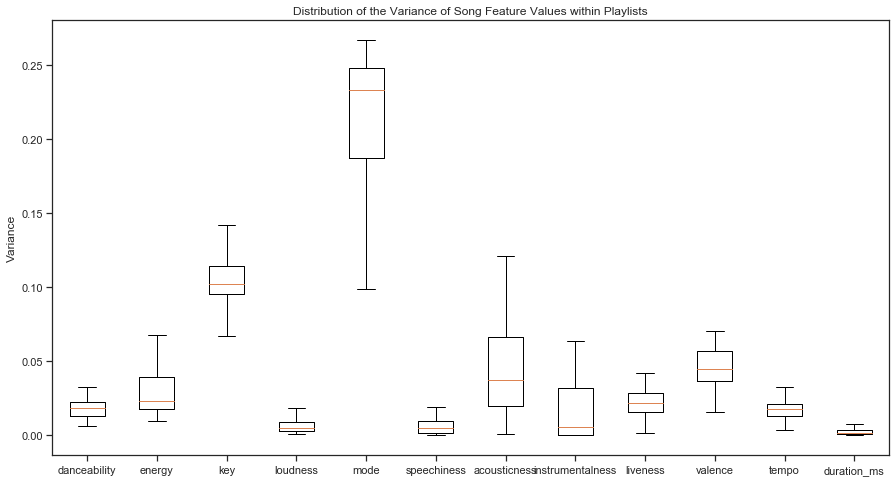

In [12]:
var_list = []

for x in range(len(col_of_interest)):
    var_list.append(playlist_variance[col_of_interest[x]])
    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,8))
ax.boxplot(var_list, showfliers=False)
ax.set_title("Distribution of the Variance of Song Feature Values within Playlists")
ax.set_ylabel("Variance")
ax.set_xticklabels(col_of_interest)

plt.show()

We also took a look at the variance in features expressed in the songs chosen for inclusion within individual playlists.  We took a subset of 50 full playlists from the Spotify API, and from this dataset, found the audio features for each song in each playlist. We then standardized the values (by each feature) so that the variance can be seen at the same scale. We then made the above boxplot, showing the distribution of the variances of each feature across the 50 playlists. 

As we can see from the above boxplots, there clearly *are* some features that tend to cluster together within playlists; for instance, danceability has on average a relatively low variance across all songs in a playlist.  This means, simply, that most of the songs in any one playlist will tend to have the same values for danceability.  This seems intuitively to make sense: playlists are often made with or without dancing in mind, so a song that is less danceable would not fit into a playlist with songs that are very danceable.  In other words, playlists may tend to select for danceability.  On the other end, acousticness and mode had relatively higher variances, meaning that these features may not necessarily be selected for in particular when people create playlists.  These trends from our EDA will be important to consider when moving on with the project.

## EDA Thought Process and Results on Songs in General

For part of our EDA, we decided it would be a good idea to look at the songs within the playlists. We derived two subsets of songs from the playlists with the audio features described above:
* One random subset of 50,000 songs
* The most popular 70,000 songs (as measured by frequency of apperance in playlists)

We wanted to compare the audio features within these two subsets to compare whether or not a simple random sample of songs would have significantly different features from a subset of the most popular songs.

We did this in two ways: using summary statistics and comparing distributions.

## Comparing Summary Statistics

In [13]:
srs_50k.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,49996.000000,49996.000000,49996.000000,49996.000000,49996.000000,49996.000000,49996.000000,49996.000000,49996.000000,49996.000000,49996.000000,4.999600e+04,49996.000000
mean,0.550618,0.585032,5.269422,-9.655672,0.654912,0.090006,0.354872,0.220637,0.208626,0.476369,120.128909,2.478844e+05,3.880330
std,0.184363,0.266107,3.565643,5.621092,0.475402,0.116390,0.354657,0.349503,0.188922,0.269302,29.914074,1.605099e+05,0.474176
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.229000e+03,0.000000
25%,0.427000,0.391000,2.000000,-11.915250,0.000000,0.035400,0.022100,0.000000,0.096000,0.250000,97.020250,1.842552e+05,4.000000
50%,0.567000,0.623000,5.000000,-8.161000,1.000000,0.047200,0.218000,0.000600,0.128000,0.467000,120.019000,2.251600e+05,4.000000
75%,0.688000,0.808000,8.000000,-5.821750,1.000000,0.084400,0.692000,0.421000,0.261000,0.695000,138.285000,2.782010e+05,4.000000
max,0.987000,1.000000,11.000000,4.472000,1.000000,0.964000,0.996000,1.000000,1.000000,1.000000,248.733000,5.823661e+06,5.000000


In [14]:
pop_70k.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,69678.000000,69678.000000,69678.000000,69678.000000,69678.000000,69678.000000,69678.000000,69678.000000,69678.000000,69678.000000,69678.000000,6.967800e+04,69678.000000
mean,0.585016,0.641262,5.241152,-7.476997,0.667671,0.088783,0.250946,0.071644,0.193273,0.478198,121.537697,2.347612e+05,3.931270
std,0.163043,0.221970,3.589362,3.865238,0.471052,0.095779,0.290335,0.208811,0.159902,0.244579,28.999635,6.936283e+04,0.352175
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.520000e+03,0.000000
25%,0.478000,0.493000,2.000000,-9.070000,0.000000,0.034800,0.018400,0.000000,0.096000,0.282000,98.416500,1.965600e+05,4.000000
50%,0.594000,0.674000,5.000000,-6.612000,1.000000,0.048100,0.116000,0.000009,0.127000,0.466000,120.732500,2.250795e+05,4.000000
75%,0.703000,0.821000,8.000000,-4.928000,1.000000,0.093200,0.416000,0.002560,0.246000,0.669000,140.000000,2.611330e+05,4.000000
max,0.988000,0.999000,11.000000,1.586000,1.000000,0.962000,0.996000,0.994000,1.000000,0.992000,236.799000,4.195000e+06,5.000000


From the summary statistics, we see that the means and standard deviations for most of the features are similar with a few exceptions. Energy has a greater mean in the popular song subset. Loudness, acousticness, instrumentalness, and duration_ms have smaller means and smaller variances in the subset of popular songs. 

However, we cannot simply rely on summary statistics to tell us everything about the data. Therefore, we will graph the distributions of the data and compare them as well.

## Comparing Distributions

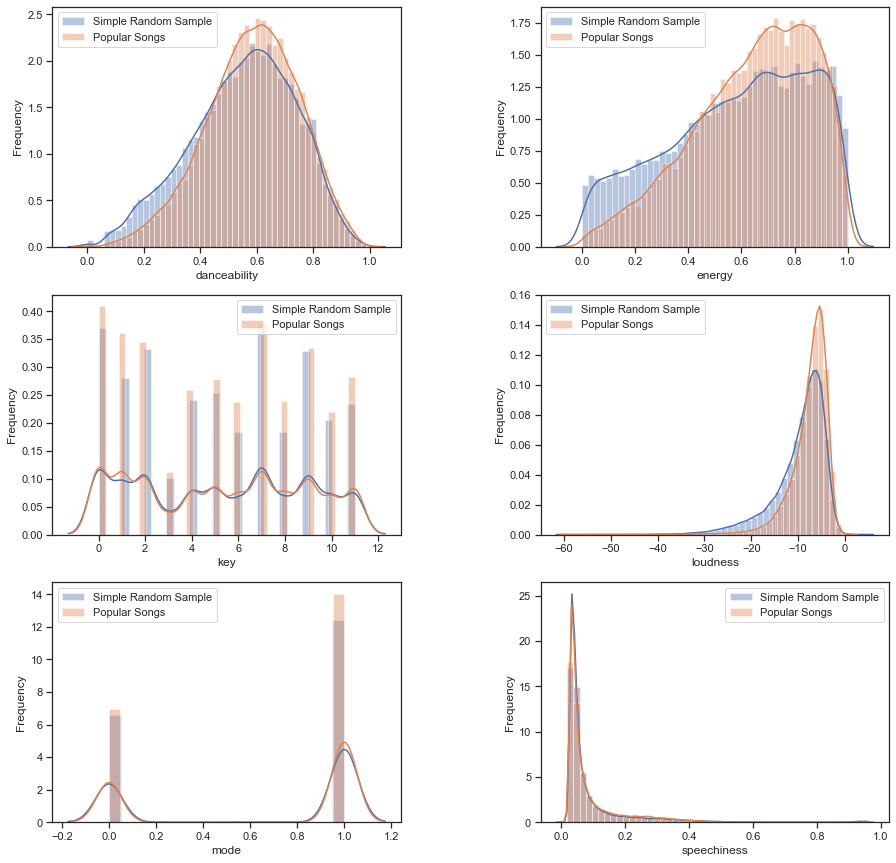

In [15]:
## Made two boxes so that our images would fit on one page
fig, ax = plt.subplots(3,2, figsize = (15,15))
fig.subplots_adjust(hspace=.2, wspace=.4)
axes = ax.ravel()

for i in range(6):
    sns.distplot(srs_50k[col_of_interest[i]], ax = axes[i], kde = True, label = "Simple Random Sample")
    sns.distplot(pop_70k[col_of_interest[i]], ax = axes[i], kde = True, label = "Popular Songs")
    axes[i].legend()
    axes[i].set_xlabel(col_of_interest[i])
    axes[i].set_ylabel("Frequency")

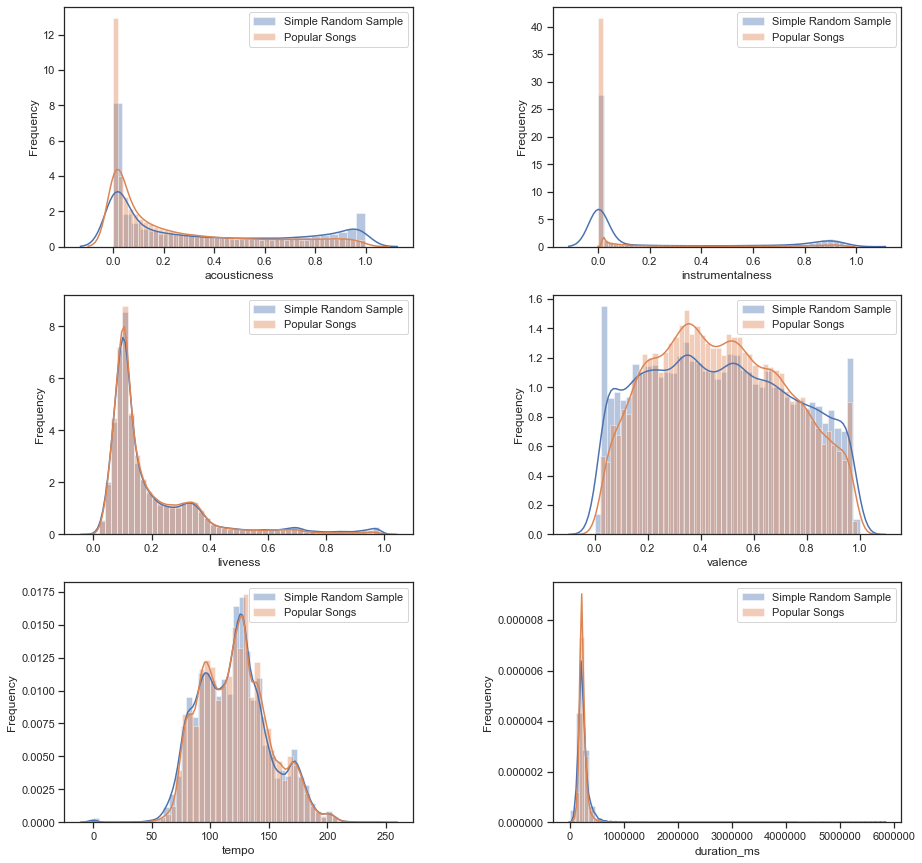

In [16]:
## Continuation of plots above
fig, ax = plt.subplots(3,2, figsize = (15,15))
fig.subplots_adjust(hspace=.2, wspace=.4)
axes = ax.ravel()

for i in range(6,12):
    sns.distplot(srs_50k[col_of_interest[i]], ax = axes[i-6], kde = True, label = "Simple Random Sample")
    sns.distplot(pop_70k[col_of_interest[i]], ax = axes[i-6], kde = True, label = "Popular Songs")
    axes[i-6].legend()
    axes[i-6].set_xlabel(col_of_interest[i])
    axes[i-6].set_ylabel("Frequency")

We wanted to check the distribution of audio features in both of these subsets and compare them to see whether or not the distributions of the random subset would be different from the distribution of the most popular songs of the playlists we have. 

From the plots above, we see that most of the distributions are not very different. The ones that we identified that are potentially different are: loudness, acousticness, energy, duration_ms, and instrumentalness. 

* In the "loudness" plot, we see greater concentration of values around 0 for the popular songs, potentially suggesting that more popular songs are louder.

* In the "acousticness" plot, we see a stronger drop off of values from 0 to 1, suggesting that the distribution of the more popular songs have less acoustic songs.

* In the "instrumentalness" plot, we see a similar steeper drop off of values from 0 to 1, suggesting that the distribution of the more popular songs have less instrumental songs as well.

* In the "energy" plot, we see that there is a greater concentration of larger values in the popular songs distribution. This suggests that more popular songs have greater energy. 

* In the "duration_ms" plot, though it hard to see, there is larger spike in smaller values for the popular songs distribution. This suggests that more popular songs are shorter in duration.

More generally, we see that the audio features have different distributions of values. We have a mix of left-skewed (energy, loudness), right-skewed (liveness, instrumentalness, acousticness, speechiness, duration_ms) and normal (danceability, tempo, valence) data. 

## Baseline Model

### Description / Approach

For our baseline model, we decided to recommend songs from a set of candidate songs according to which of these candidates have the highest average cosine similarity to the set of seed songs. To elaborate, the function is applied pairwise between each candidate and each seed song and then the output is averaged across the seed songs giving an average similarity for each candidate. In other words, playlists are generated using an unsupervised algorithm that attempts to maximize a score function and can generate playlists of any length up to the number of provided candidate songs. For our purposes, we used a collection of around 220,000 candidate songs, which is noteably 1/10th of all unique songs used to create playlists in our dataset.

This approach is motivated by the assumption that different playlists have different distributions of features, perhaps according to genre for example, and that songs that are tonally similar will be a good recommendation for that playlist.

This leaves us with a couple of ways to improve performance. First, our baseline model used `"danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "mode"` to measure difference, however this selection of features could certainly be tuned for model performance. Second, this similarity function could be changed completely, perhaps using a supervised ML algorithm such as a neural network where the algorithm predicts similarity between songs trained on top spotify playlists, while preserving the structure of our baseline model.

### Evaluation

To evaluate our baseline model, we randomly selected 50 playlists and retrieved all of their songs to ensure that we had musical features on all of the playlist entries. Next, we split these playlists into a set of "seed" songs and evaluation songs of sizes 0.75 and 0.25, respectively. Finally, we used our baseline model to predict 500 songs that our model deemed as best matches. We then compared these predictions to the left-out test set and recorded the percentage of the playlist songs that were predicted correctly. Using this metric, our model predicted $2.5\%$ of the test set correctly on average.

Furthermore, we record the positions of the correctly predicted test set where 1 is considered a better match than 500. Looking at this data, we see that there are a few playlists where the model gets many of the test set correct and other playlists where the baseline model predicted none of the original songs. This might suggest that some playlists are tonally similar while others are less so; this may motivate another angle of approach that attempts to use related artists to those found in the seed songs to avoid only suggesting tonally similar songs.

In [17]:
available_features = ["danceability", "energy", "loudness", 
                      "speechiness", "acousticness", 
                      "instrumentalness", "liveness", "valence", "mode"]

In [38]:
class Baseline:
    def __init__(self, X_train, X_test, songs_df, candidate_song_ids = None, 
                 candidate_percentage = 0.3, similarity = "cosine"):
        self.X_train = X_train
        self.X_test = X_test
        self.songs_df = songs_df
        sids = set(songs_df["id"])
        self.sids = sids
        if candidate_song_ids:
            # make sure the ids are in the songs_df
            assert(sum([0 if i in sids else 1 for i in candidate_songs_ids]) == 0)
            self.candidate_songs = songs_df.loc[songs_df["id"].isin(candidate_song_ids)]
        else:
            self.setCandidateSongs(candidate_percentage)
        
        if similarity == "cosine":
            self.sim_func = cosine_similarity
        else:
            raise NotImplementedError("This similarity function is not currently supported.")
            
        # used song set?
        self.used_song_ids = set()
        
        
    def setCandidateSongs(self, percentage):
        ids = random.sample(list(self.sids), int(percentage * len(self.sids)))
        self.candidate_songs = self.songs_df.loc[self.songs_df["id"].isin(ids)]
        
    
    def predict(self, seed_songs_df, num_songs, feats_to_use):
        songs_to_consider = self.candidate_songs.loc[-self.candidate_songs["id"].isin(list(seed_songs_df["id"]))]
        similarities = self.sim_func(seed_songs_df[feats_to_use].values, 
                                     songs_to_consider[feats_to_use].values)
        avg_sim = np.mean(similarities, axis = 0)
        desc_order = np.argsort(-avg_sim)
        songs_desc = songs_to_consider.iloc[desc_order]
        return songs_desc[0:num_songs]

In [66]:
complete_playlists = pd.read_csv("complete_playlists_50.csv")
unique_playlists = complete_playlists.groupby(by=["fid", "pid"]).pos.first().reset_index().drop("pos", axis=1)
total_songs = pd.read_csv("total_songs_clean.csv")

In [69]:
percent = 3/4
test_size = 0
num_correct = 0
position_list = {}
random.seed(109)

for i in range(len(unique_playlists)): #len(unique_playlists)
    fid = unique_playlists.loc[i, "fid"]
    pid = unique_playlists.loc[i, "pid"]
    playlist = complete_playlists.loc[(complete_playlists["fid"] == fid) & 
                                      (complete_playlists["pid"] == pid)].reset_index(drop=True)
    
    seed_ids = random.sample(list(range(playlist.shape[0])), int(playlist.shape[0] * percent))
    seed_split = playlist.index.get_level_values(0).isin(seed_ids)
    seed = playlist.loc[seed_split]
    test = playlist.loc[~seed_split]
    test_song_ids = set(test["id"])
    test_size += test.shape[0]
    evaluate = Baseline("not", "implemented", total_songs, candidate_percentage=1)
    predictions = evaluate.predict(seed, 500, available_features).reset_index()
    num_correct += predictions.loc[predictions["id"].isin(test_song_ids)].shape[0]
    position_list[(fid, pid)] = (list(predictions.loc[predictions["id"].isin(test_song_ids)].index.get_level_values(0)))

In [70]:
position_list

{(16, 705): [],
 (29, 736): [],
 (52, 746): [],
 (112, 480): [167, 318, 358, 451],
 (113, 190): [],
 (124, 951): [],
 (149, 299): [204],
 (164, 985): [96],
 (167, 82): [],
 (172, 599): [],
 (176, 116): [],
 (226, 831): [],
 (246, 757): [361],
 (320, 851): [134, 142],
 (334, 229): [],
 (341, 453): [266, 486],
 (342, 824): [],
 (346, 794): [],
 (354, 557): [],
 (356, 420): [],
 (361, 820): [],
 (386, 719): [],
 (392, 266): [],
 (420, 39): [],
 (429, 375): [],
 (436, 869): [],
 (447, 778): [107, 157, 348, 451, 479, 485],
 (451, 640): [387],
 (508, 314): [],
 (526, 566): [],
 (560, 929): [],
 (680, 108): [196, 215],
 (718, 872): [],
 (735, 66): [],
 (759, 574): [],
 (770, 309): [],
 (812, 749): [],
 (819, 419): [],
 (823, 120): [],
 (828, 766): [336],
 (858, 844): [350, 386],
 (859, 769): [],
 (863, 519): [],
 (865, 866): [],
 (892, 979): [],
 (897, 643): [],
 (921, 300): [],
 (964, 992): [],
 (965, 905): [],
 (998, 452): []}

In [71]:
num_correct / test_size

0.02505446623093682

## Refining Our Project Questions

Our next project question, at its most fundamental, is how
can we improve our baseline model?

More specifically:

* What portions of our model can we have supervised learning and which portions of our model should we have unsupervised learning?

* How can we improve our evaluation method? Is there a way to incorporate user feedback - perhaps by evaluating our performance on the top playlists on Spotify?

# Collaborative Filtering

In [43]:
# Note: due to time restraints of compiling this notebook because we had to combine multiple and
# do not have their output, we are running the below for 5 files

In [20]:
random.seed(109)
file_ids = random.sample(range(1000), 5)
file_list = [f"songs{i}.csv" for i in file_ids]

In [21]:
files_list = []
for i in range(len(file_list)):
    file_path = "Songs/" + file_list[i]
    file = pd.read_csv(file_path)
    file["fid"] = file_ids[i]
    files_list.append(file)
complete_playlists = pd.DataFrame(np.concatenate(files_list), columns = file.columns)
complete_playlists.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,fid
0,0,0,Sam Smith,spotify:track:7Hz6LLOVxrojLPIHJJ1S0E,spotify:artist:2wY79sveU1sp5g7SokKOiI,Have Yourself A Merry Little Christmas,spotify:album:6aT8FGBTfyAhIDQ0IDaebz,170964,Have Yourself A Merry Little Christmas,286
1,0,1,Bing Crosby,spotify:track:6Z8bwTp3CPk8fAomqEJZHc,spotify:artist:6ZjFtWeHP9XN7FeKSUe80S,Have Yourself A Merry Little Christmas,spotify:album:0RybBCL0oKCwyKur97W2gH,169506,Winter Wonderland,286
2,0,2,Dean Martin,spotify:track:7H0ABcbcZLjVD83SgeU19l,spotify:artist:49e4v89VmlDcFCMyDv9wQ9,White Christmas,spotify:album:5I48ENiZiaZZSOpec6PdS5,149920,A Winter Romance,286
3,0,3,Vince Guaraldi Trio,spotify:track:34rzJNfTd5e9s3TICFMPD0,spotify:artist:4ytkhMSAnrDP8XzRNlw9FS,O Tannenbaum,spotify:album:7DuJYWu66RPdcekF5TuZ7w,309386,A Charlie Brown Christmas,286
4,0,4,Michael Bublé,spotify:track:0lLdorYw7lVrJydTINhWdI,spotify:artist:1GxkXlMwML1oSg5eLPiAz3,It's Beginning To Look A Lot Like Christmas,spotify:album:3CKVXhODttZebJAzjUs2un,206346,Christmas,286


# Set index to ["fid", "pid"]

In [22]:
complete_playlists.set_index(["fid", "pid"], inplace=True)
complete_playlists.sort_index(inplace = True) # Sort index to make indexing faster later

# Get all unique songs, artists, and albums for Collaborative Filtering

In [23]:
all_unique_songs = complete_playlists['track_name'].unique()
all_unique_albums = complete_playlists['album_name'].unique()
all_unique_artists = complete_playlists['artist_name'].unique()

# Make unique playlist ID's and split into train and test

In [24]:
unique_playlist_ids = np.unique(complete_playlists.index.values)
np.random.shuffle(unique_playlist_ids)

# 0.8 Test and 0.2 Train Split
train_idx_cutoff = int(0.8 * unique_playlist_ids.shape[0])
train_playlist_ids = unique_playlist_ids[0:train_idx_cutoff]
test_playlist_ids = unique_playlist_ids[train_idx_cutoff:unique_playlist_ids.shape[0]]

# Create Sparse Matrix

In [25]:
# Create sparse matrix based on passed in filter methods
def createSparseMatrix(train_playlist_ids, all_candidates_filter, filter_method = "track_name"):    
    rows_list = []
    for ids in train_playlist_ids:
        playlist_filter = complete_playlists.loc[pd.IndexSlice[ids]][filter_method]
        ones_idx = np.where(np.isin(all_candidates_filter, playlist_filter))[0]
        row = np.zeros(all_candidates_filter.shape)
        row[ones_idx] = 1 / playlist_filter.shape[0]
        rows_list.append(row)
    train_sparse = sp.sparse.csr_matrix(np.vstack(rows_list))
    return train_sparse

In [26]:
song_sm = createSparseMatrix(train_playlist_ids, all_unique_songs, "track_name")
artist_sm = createSparseMatrix(train_playlist_ids, all_unique_artists, "artist_name")
album_sm = createSparseMatrix(train_playlist_ids, all_unique_albums, "album_name")

# kNN with Collaborative Filtering on Songs

In [27]:
model_knn_songs = NearestNeighbors(metric='cosine', 
                                   algorithm='brute', 
                                   n_neighbors=50, n_jobs=-1).fit(song_sm)
model_knn_albums = NearestNeighbors(metric='cosine', 
                                    algorithm='brute', 
                                    n_neighbors=50, n_jobs=-1).fit(album_sm)
model_knn_artists = NearestNeighbors(metric='cosine', 
                                     algorithm='brute', 
                                     n_neighbors=50, n_jobs=-1).fit(artist_sm)

# Create Sparse Vector for Test Playlists

In [28]:
def createSparseVector(test_playlist, all_candidates_filter, filter_method = "track_name"):
    # Takes a playlist and creates a sparse vector
    test_playlist_filter = test_playlist[filter_method]
    ones_idx = np.where(np.isin(all_candidates_filter, test_playlist_filter))
    row = np.zeros(all_candidates_filter.shape)
    row[ones_idx] = 1
    return row

# Split Test Set into Train and Validation

test_playlist_ids: These are the ids for the playlists that we want to make predictions on
- We split each test playlist into a "train" and "validation" set. 
- We create sparse matrices from the train part, to create a similarity value for the test playlist to existing playlists in our database. 3 are created for our 3 collaborative filtering techniques
- Then, we use the similarity value to choose playlists that are most similar and recommend the songs from that playlist

In [29]:
random.seed(109)
# Sparse matrices for the three collaborative filtering techniques
song_sm_list = []
album_sm_list = []
artist_sm_list = []
# Creating a list of validation songs that we later test against
val_list = []
test_list = []

# For each playlist in test playlists
for ids in test_playlist_ids:
    test_playlist = complete_playlists.loc[ids]
    
    # Split into test songs and validation songs
    idx = np.random.choice(np.arange(len(test_playlist)), int(0.8 * len(test_playlist)), replace=False)
    test_idx = np.where(np.isin(np.arange(len(test_playlist)), idx, invert=True))[0]
    predictor_playlist = test_playlist.iloc[idx]
    evaluation_playlist = test_playlist.iloc[test_idx]
    val_list.append(evaluation_playlist)
    test_list.append(predictor_playlist)
    
    # Make the sparse vector for each test playlist - cf on songs
    sparse_song_row = createSparseVector(predictor_playlist, all_unique_songs, "track_name")
    song_sm_list.append(sparse_song_row)
    
    # Make the sparse vector for each test playlist - cf on album
    sparse_album_row = createSparseVector(predictor_playlist, all_unique_albums, "album_name")
    album_sm_list.append(sparse_album_row)
    
    # Make the sparse vector for each test playlist - cf on artist
    sparse_artist_row = createSparseVector(predictor_playlist, all_unique_artists, "artist_name")
    artist_sm_list.append(sparse_artist_row)

# Compile all vectors for test playlists into a sparse matrix
test_song_sm = sp.sparse.csr_matrix(np.vstack(song_sm_list))
test_album_sm = sp.sparse.csr_matrix(np.vstack(album_sm_list))
test_artist_sm = sp.sparse.csr_matrix(np.vstack(artist_sm_list))

# Store the validation sets of each playlist
val_df = pd.concat(val_list)
test_indices = test_playlist_ids

# Prediction Function

In [30]:
def getSongPredictions(X, model, train_indices, candidate_playlists, top_n, test_list, filter_method):
    distances, neighbors = model.kneighbors(X)
    predictions_list = []
    # For each playlist in the sparse matrix passed in
    for i in range(len(test_list)):
        best_candidates = neighbors[i][distances[i] != 1]
        best_distances = distances[i][distances[i] != 1]
        if best_candidates.size != 0:
            # get the IDs in candidate_playlists [our database of playlists] with the lowest distance
            candidate_idx = train_indices[best_candidates]
        else:
            predictions_list.append(pd.DataFrame(columns = candidate_playlists.columns))
            continue
            
        candidates_df = candidate_playlists.loc[candidate_idx]
        
        # transform the best_distances into a form that can be concatenated
        lengths = candidates_df.groupby(level=[0,1])["pos"].count().values
        candidates_df[f"{filter_method}_distance"] = np.repeat(best_distances, lengths)
        
        # want only the songs that are not in the test playlist
        idx_songs_in_playlist = np.where(np.isin(candidates_df["track_name"].values,
                                                 test_list[i]["track_name"].values, invert=True))[0]
        not_in_train_df = candidates_df.loc[idx_songs_in_playlist]
        
        # drop duplicates from final recommendation list
        no_duplicates_df = not_in_train_df.drop_duplicates("track_name")
        if no_duplicates_df.shape[0] < top_n:
            predictions_list.append(no_duplicates_df)
        else:
            predictions_list.append(no_duplicates_df.iloc[0:top_n])
    return predictions_list

# Prediction with CF on Songs

In [31]:
predictions_cf_song = getSongPredictions(test_song_sm, model_knn_songs, 
                                         train_playlist_ids, complete_playlists, 
                                         500, test_list, "song")

# Prediction with CF on Artists

In [32]:
predictions_cf_artist = getSongPredictions(test_artist_sm, model_knn_artists, 
                                           train_playlist_ids, complete_playlists, 
                                           500, test_list, "artist")

# Prediction with CF on Album

In [33]:
predictions_cf_album = getSongPredictions(test_album_sm, model_knn_albums, 
                                          train_playlist_ids, complete_playlists, 
                                          500, test_list, "album")

# Evaluation Methods

In [34]:
def clickEvaluation(val_list, predictions_list):
    clicks = []
    for i in range(len(val_list)):
        predictions = predictions_list[i]
        val_playlist = val_list[i]
        positions_matching = np.where(np.isin(predictions["track_name"].values, val_playlist['track_name'].values))[0]
        if positions_matching.size == 0:
            clicks.append(50)
        else:
            clicks.append(math.floor(positions_matching[0] / 10))
    return np.mean(clicks)

In [35]:
def AdjustedRPrecision(predictions_list, val_list):
    # Takes a list of df's of predicted songs and a list of df's of validation playlist
    adjusted_r_precision_list = list()
    precision_list = list()
    valid_predictions_list = list()
    for i in range(len(predictions_list)):
        if len(predictions_list[i]) == 0:
            adjusted_r_precision_list.append(0)
            continue
        valid_song = np.isin(predictions_list[i]["track_name"], val_list[i]["track_name"]) 
        valid_artist = np.isin(predictions_list[i]["artist_name"], val_list[i]["artist_name"])
        valid_album = np.isin(predictions_list[i]["album_name"], val_list[i]["album_name"])
        valid_predictions = (valid_song | valid_artist | valid_album).astype(int)
        valid_predictions_list.append(valid_predictions)
        precision_list.append(valid_song.astype('int'))
        adjusted_r_precision_list.append(sum(valid_predictions) / predictions_list[i].shape[0])
        
    return adjusted_r_precision_list, valid_predictions_list, precision_list

In [36]:
# Mean clicks for songs
clickEvaluation(val_list, predictions_cf_song)

13.125

In [37]:
adjusted_r_precision_list, valid_predictions_list, _ = AdjustedRPrecision(predictions_cf_song, val_list)

In [38]:
# Mean precision for songs
np.mean(adjusted_r_precision_list)

0.07994778762180167

In [39]:
# Mean clicks for artists
clickEvaluation(val_list, predictions_cf_artist)

13.368

In [40]:
# Mean precision for artists
adjusted_r_precision_list, valid_predictions_list, _ = AdjustedRPrecision(predictions_cf_artist, val_list)
np.mean(adjusted_r_precision_list)

0.08512138573899673

In [41]:
# Mean clicks for albums
clickEvaluation(val_list, predictions_cf_album)

12.682

In [45]:
# Mean precision for albums
adjusted_r_precision_list, valid_predictions_list, _ = AdjustedRPrecision(predictions_cf_album, val_list)
np.mean(adjusted_r_precision_list)

0.08735692857142859

# Create Training Matrix for ANN

In [46]:
tracks_to_consider = pd.read_csv("acoustic_features_10k_playlists.csv").set_index("uri")
desired_features = ["danceability", "energy", "loudness", 
                      "speechiness", "acousticness", 
                      "instrumentalness", "liveness", "valence", "mode"]

In [47]:
rows_list = []
for i in range(len(predictions_cf_song)):
    to_concat = []
    if predictions_cf_song[i].shape[0] != 0:
        to_concat.append(predictions_cf_song[i])
    if predictions_cf_album[i].shape[0] != 0:
        to_concat.append(predictions_cf_album[i])
    if predictions_cf_artist[i].shape[0] != 0:
        to_concat.append(predictions_cf_artist[i])
    if not to_concat:
        rows_list.append([])
        continue
        
    total = pd.concat(to_concat, axis=0, sort=False)
    if "song_distance" not in total.columns:
        total["song_distance"] = np.nan
    if "artist_distance" not in total.columns:
        total["artist_distance"] = np.nan
    if "album_distance" not in total.columns:
        total["album_distance"] = np.nan
        
    total_grouped = total.groupby("track_name", sort=False)
    unique_preds = total.drop_duplicates("track_name").copy().reset_index()
    unique_preds['song_distance'] = total_grouped['song_distance'].max().reset_index(drop=True)
    unique_preds['artist_distance'] = total_grouped['artist_distance'].max().reset_index(drop=True)
    unique_preds['album_distance'] = total_grouped['album_distance'].max().reset_index(drop=True)
    unique_preds.set_index(["fid", "pid"], inplace=True)
    unique_preds.sort_index(inplace=True)
    
    # get where we are missing values
    missing_vals_idx = np.unique(unique_preds.loc[unique_preds['song_distance'].isna() 
                                         | unique_preds['artist_distance'].isna()
                                         | unique_preds['album_distance'].isna()].index)
    
    for idx in missing_vals_idx:
        train_row = np.where([train_id == idx for train_id in train_playlist_ids])[0][0]
        song_val = cosine_distances(song_sm[train_row], test_song_sm[i])[0][0]
        artist_val = cosine_distances(artist_sm[train_row], test_artist_sm[i])[0][0]
        album_val = cosine_distances(album_sm[train_row], test_album_sm[i])[0][0]
        unique_preds.loc[idx, ('song_distance', 'artist_distance', 'album_distance')] = (song_val, artist_val, album_val)
        
    # add cosine similarity with musical features
    pred_feats = tracks_to_consider.loc[unique_preds['track_uri'], desired_features]
    test_feats = tracks_to_consider.loc[test_list[i]['track_uri'], desired_features]
    avg_sim = np.mean(cosine_similarity(test_feats, pred_feats), axis=0)
    unique_preds['musical_similarity'] = avg_sim
    unique_preds['num_seed_songs'] = test_list[i].shape[0]
    
    # Add validation fid, pid
    unique_preds['val_fid'] = val_list[i].index[0][0]
    unique_preds['val_pid'] = val_list[i].index[0][1]
    
    rows_list.append(unique_preds)

In [48]:
adjusted_r_precision_list, valid_predictions_list, precision_list = AdjustedRPrecision(rows_list, val_list)

In [50]:
response = np.concatenate(precision_list)
filtered_rows = []
for row in rows_list:
    if len(row) > 0:
        filtered_rows.append(row)
nn_train_df = pd.concat(filtered_rows, sort=False)
nn_train_df['response'] = response
scaled_duration = StandardScaler().fit_transform(nn_train_df['duration_ms'].values.reshape(-1,1))
nn_train_df['scaled_duration'] = scaled_duration.reshape(-1,)
final_features_train = nn_train_df[['scaled_duration', 'num_seed_songs', 'song_distance', 'artist_distance', 'album_distance', 'musical_similarity', 'response', 'val_fid', 'val_pid']]
final_features_train.to_csv("nn_train_5.csv")

# Use Musical Features to Order the Predictions

In [49]:
sorted_list = []
for i in range(len(predictions_cf_song)):
    to_concat = []
    
    if predictions_cf_album[i].shape[0] != 0:
        to_concat.append(predictions_cf_album[i])
    if predictions_cf_artist[i].shape[0] != 0:
        to_concat.append(predictions_cf_artist[i])
    if predictions_cf_song[i].shape[0] != 0:
        to_concat.append(predictions_cf_song[i])
    if not to_concat:
        sorted_list.append([])
        continue
    
    total = pd.concat(to_concat, axis=0, sort=False)
    unique_preds = total.drop_duplicates("track_name").copy()
    
    # add cosine similarity with musical features
    pred_feats = tracks_to_consider.loc[unique_preds['track_uri'], desired_features]
    test_feats = tracks_to_consider.loc[test_list[i]['track_uri'], desired_features]
    avg_sim = np.mean(cosine_similarity(test_feats, pred_feats), axis=0)
    unique_preds['musical_similarity'] = avg_sim
    sorted_preds = unique_preds.sort_values('musical_similarity', ascending=False)
    top_500 = sorted_preds[0:500] if sorted_preds.shape[0] > 500 else unique_preds
    
    sorted_list.append(top_500)

In [51]:
adjusted_r_precision_list, valid_predictions_list, precision_list = AdjustedRPrecision(sorted_list, val_list)
np.mean(adjusted_r_precision_list)

0.078774

In [52]:
clicks = []
for i in range(len(val_list)):
    predictions = sorted_list[i]
    val_playlist = val_list[i]
    if len(predictions) == 0:
        clicks.append(50)
        continue
    positions_matching = np.where(np.isin(predictions["track_name"].values, val_playlist['track_name'].values))[0]
    if positions_matching.size == 0:
        clicks.append(50)
    else:
        clicks.append(math.floor(positions_matching[0] / 10))
np.mean(clicks)

16.921

# Order Naively

In [53]:
sorted_list = []
for i in range(len(predictions_cf_song)):
    to_concat = []
    
    if predictions_cf_album[i].shape[0] != 0:
        to_concat.append(predictions_cf_album[i])
    if predictions_cf_artist[i].shape[0] != 0:
        to_concat.append(predictions_cf_artist[i])
    if predictions_cf_song[i].shape[0] != 0:
        to_concat.append(predictions_cf_song[i])
    if not to_concat:
        sorted_list.append([])
        continue
        
    total = pd.concat(to_concat, axis=0, sort=False)
    unique_preds = total.drop_duplicates("track_name").copy()
    
    # add cosine similarity with musical features
    top_500 = unique_preds[0:500] if unique_preds.shape[0] > 500 else unique_preds
    
    sorted_list.append(top_500)

In [54]:
adjusted_r_precision_list, valid_predictions_list, precision_list = AdjustedRPrecision(sorted_list, val_list)
np.mean(adjusted_r_precision_list)

0.08744600000000001

In [55]:
clicks = []
for i in range(len(val_list)):
    predictions = sorted_list[i]
    val_playlist = val_list[i]
    if len(predictions) == 0:
        clicks.append(50)
        continue
    positions_matching = np.where(np.isin(predictions["track_name"].values, val_playlist['track_name'].values))[0]
    if positions_matching.size == 0:
        clicks.append(50)
    else:
        clicks.append(math.floor(positions_matching[0] / 10))
np.mean(clicks)

12.591

# Train ANN

In [56]:
nn_train = pd.read_csv("nn_train.csv").set_index(["fid", "pid"])
nn_train.head()

scaled_duration  num_seed_songs  song_distance  artist_distance  \
fid pid                                                                    
59  549        -0.269296             169       0.830842         0.676425   
    549        -0.707113             169       0.830842         0.676425   
    549        -0.117009             169       0.830842         0.676425   
    549        -0.807887             169       0.830842         0.676425   
    549        -0.650126             169       0.830842         0.676425   

         album_distance  musical_similarity  response  
fid pid                                                
59  549        0.689833            0.976354         1  
    549        0.689833            0.980082         1  
    549        0.689833            0.980873         1  
    549        0.689833            0.981221         1  
    549        0.689833            0.980248         1

In [60]:
X_train, X_test, y_train, y_test = train_test_split(nn_train.drop("response", axis=1), 
                                                    nn_train["response"], 
                                                    train_size=5/46, 
                                                    random_state=42)

In [61]:
# distance from 3 colab filters + cosine distance of features + number of seed songs

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation='relu', input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# opt = tf.keras.optimizers.SGD(lr=0.2)
model.compile(loss='binary_crossentropy', optimizer="adam", metrics = ['accuracy'])

In [62]:
# try class weightings
from sklearn.utils import compute_class_weight
classWeight = compute_class_weight('balanced', [0,1], nn_train["response"].values) 
classWeight = dict(enumerate(classWeight))

In [63]:
history = model.fit(X_train.values, y_train.values, validation_split=0.2, epochs=5, 
                    verbose=0, batch_size=64, class_weight=classWeight)

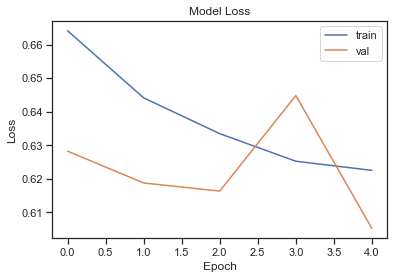

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

# Evaluate ANN Predictions

In [72]:
nn_test = pd.read_csv("nn_train_5_clicks.csv").set_index(["val_fid", "val_pid"])
nn_test.sort_index(inplace = True)

In [73]:
ids = nn_test.index.unique().values
original_clicks = []
new_clicks = []
for i in ids:
    X = nn_test.loc[i]
    positions_matching = np.where(X['response'].values == 1)[0]
    if positions_matching.size == 0:
        original_clicks.append(50)
        new_clicks.append(50)
    else:
        o_click = math.floor(positions_matching[0] / 10)
        original_clicks.append(o_click if o_click < 50 else 50)
        predictions = model.predict(X.drop(["fid", "pid", "response"], axis=1).values)
        X_pred = X.copy()
        X_pred['predictions'] = predictions
        sorted_response = X_pred.sort_values("predictions", ascending=False)["response"].values
        positions_matching = np.where(sorted_response == 1)[0]
        n_click = math.floor(positions_matching[0] / 10)
        new_clicks.append(n_click if n_click < 50 else 50)

In [74]:
np.mean(original_clicks)

21.606820461384153

In [75]:
np.mean(new_clicks)

14.898696088264794

In [76]:
nn_test = pd.read_csv("nn_train_5_r.csv").set_index(["val_fid", "val_pid"])
nn_test.sort_index(inplace = True)

In [77]:
adjusted_precision = []
for i in ids:
    X = nn_test.loc[i]
    predictions = model.predict(X.drop(["fid", "pid", "response"], axis=1).values)
    X_pred = X.copy()
    X_pred['predictions'] = predictions
    sorted_response = X_pred.sort_values("predictions", ascending=False)["response"].values
    top_500 = sorted_response[0:500] if sorted_response.shape[0] > 500 else sorted_response
    adjusted_precision.append(sum((top_500 == 1).astype("int")) / top_500.shape[0])

In [78]:
np.mean(adjusted_precision)

0.08388164493480442

# Visualizations

In [79]:
clicks_df = pd.read_csv('clickeval.csv')
rprecis_df = pd.read_csv('rprecis.csv')
clicks_df.head()

,Number of Files,CF on Songs,Artists,Albums
0,1,21.235,19.400,19.120
1,2,15.490,16.310,14.690
2,3,14.178,14.787,14.062
3,5,13.125,13.368,12.682
4,10,11.276,12.225,10.993


In [81]:
clickNN = pd.read_csv('ClickEvalwNN.csv')
rNN = pd.read_csv('RpwNN.csv')

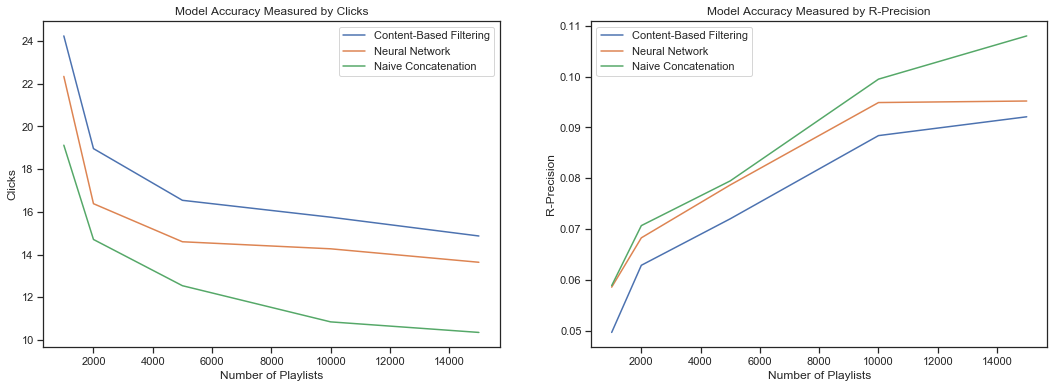

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axes[0].plot(clickNN['Number of Playlists'], clickNN['Content-Based Filtering'])
axes[0].plot(clickNN['Number of Playlists'], clickNN['Neural Network'])
axes[0].plot(clickNN['Number of Playlists'], clickNN['Naive Concatenation'])
axes[0].legend(['Content-Based Filtering', 'Neural Network', 'Naive Concatenation'])
axes[0].set_xlabel('Number of Playlists')
axes[0].set_title('Model Accuracy Measured by Clicks')
axes[0].set_ylabel('Clicks')

axes[1].plot(clickNN['Number of Playlists'], rNN['Content-Based Filtering'])
axes[1].plot(clickNN['Number of Playlists'], rNN['Neural Network'])
axes[1].plot(clickNN['Number of Playlists'], rNN['Naive Concatenation'])
axes[1].legend(['Content-Based Filtering', 'Neural Network', 'Naive Concatenation'])
axes[1].set_xlabel('Number of Playlists')
axes[1].set_title('Model Accuracy Measured by R-Precision')
axes[1].set_ylabel('R-Precision')
plt.show()

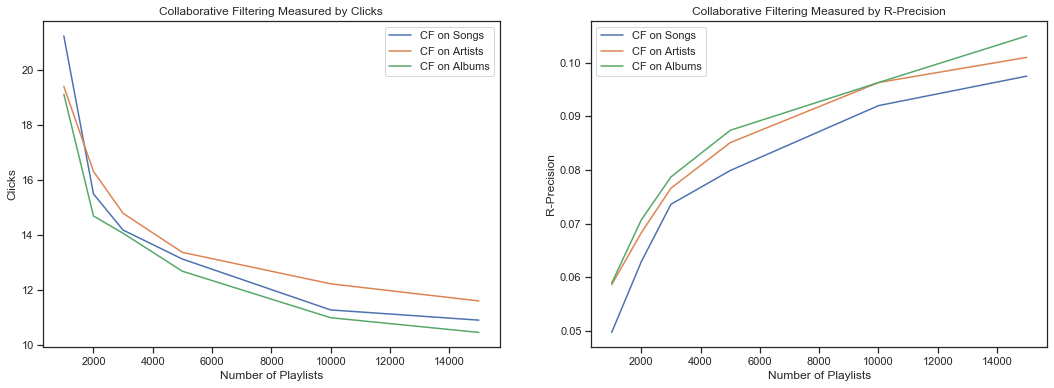

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axes[0].plot(clicks_df['Number of Files']*1000, clicks_df['CF on Songs'])
axes[0].plot(clicks_df['Number of Files']*1000, clicks_df['Artists'])
axes[0].plot(clicks_df['Number of Files']*1000, clicks_df['Albums'])
axes[0].legend(['CF on Songs', 'CF on Artists', 'CF on Albums'])
axes[0].set_xlabel('Number of Playlists')
axes[0].set_title('Collaborative Filtering Measured by Clicks')
axes[0].set_ylabel('Clicks')

axes[1].plot(rprecis_df['Number of Files']*1000, rprecis_df['CF on Songs'])
axes[1].plot(rprecis_df['Number of Files']*1000, rprecis_df['Artists'])
axes[1].plot(rprecis_df['Number of Files']*1000, rprecis_df['Albums'])
axes[1].legend(['CF on Songs', 'CF on Artists', 'CF on Albums'])
axes[1].set_xlabel('Number of Playlists')
axes[1].set_title('Collaborative Filtering Measured by R-Precision')
axes[1].set_ylabel('R-Precision')
plt.show()